# El problema de las tarjetas numeradas

Problema 4 del boletín: Se tienen diez tarjetas, numeradas de 1 a 10. El problema consiste en disponer esas tarjetas en dos pilas, $P_1$ y $P_2$, de tal forma que la suma de los números de las tarjetas en $P_1$ sea lo más próxima posible a 36 y el producto de los números de las tarjetas en $P_2$ sea los más próximo posible a 360.

Para resolver el problema mediante algoritmos genéticos definimos los parámetros necesarios de la siguiente manera:
* Los genes son 0 y 1.
* Los individuos son cromosomas de longitud 10.
* Cada individuo representa la solución en la que la tarjeta $i$-ésima va a la pila $P_1$ si el gen $i$-ésimo es 0 y a la pila $P_2$ si es 1.
* La evaluación del fenotipo de cada individuo es la diferencia en valor absoluto de la suma de las tarjetas en la pila $P_1$ con respecto a 36, más la diferencia en valor absoluto del producto de las tarjetas en $P_2$ con respecto a 360.

Se trata entonces de un problema de minimización, donde la solución perfecta sería la evaluada con 0.

## Paquete DEAP

El paquete de _Python_ [DEAP](https://deap.readthedocs.io/en/master/) proporciona un marco de trabajo para la computación evolutiva, en particular los algoritmos genéticos.

Es necesario instalar el paquete deap para realizar la práctica:

In [2]:
!pip install deap

Si la instrucción anterior produce un error, probablemente sea un problema de permisos. En este caso, prueba la siguiente instrucción:

In [3]:
#!pip install --user deap

**Importante:** Para que los cambios tengan efecto, debes reiniciar el kernel (menu Kernel > Restart), o en su defecto, cerrar completamente Anaconda y volver a abrirlo. No es suficiente con cerrar y abrir el notebook. Para comprobar que todo está correcto, ejecuta la siguiente viñeta para cargar la librería. Si no recibes ningún error es que el paquete DEAP ha sido instalado correctamente.

En primer lugar, importamos los módulos necesarios:

In [ ]:
import random
from deap import base, creator, tools, algorithms
import numpy

En la literatura acerca de los algoritmos genéticos podemos encontrar multitud de maneras de representar los individuos. Debido a ello, el paquete DEAP no proporciona representaciones concretas, sino que implementa un mecanismo general para declararlas. Para atenernos a la representación de un individuo como una secuencia de genes considerada en clase, declararemos una clase _Individuo_ que herede del tipo _list_ de _Python_.

Todo individuo debe tener un atributo `fitness` que guarde su evaluación. Hay que tener en cuenta no obstante que el paquete DEAP trata a la optimización uniobjetivo, en la que a cada individuo se le asocia un único valor de _fitness_, como un caso particular de optimización multiobjetivo, en la que a cada individuo se le asocian varios valores de _fitness_, con un determinado peso cada uno. Es por ello que el valor que se guarde en el atributo `fitness` de cada individuo será una tupla con el valor de cada función _fitness_ multiplicado por el peso asociado.

Por tanto, para representar las evaluaciones de los individuos deberemos declarar una clase que herede de la clase `base.Fitness` (que se encargará de automatizar el producto de los valores por los pesos) y en la que establezcamos en el atributo `weights` una tupla con los valores de los pesos, como números reales. En el caso de la optimización uniobjetivo, que es la considerada en clase, trabajaríamos con tuplas de longitud 1. Debe tenerse en cuenta que los algoritmos implementados en el paquete DEAP tratan de encontrar el individuo con evaluación máxima, por lo que para un problema de maximización bastaría usar la tupla `(1.0,)` como valor para el atributo `weights`. Para un problema de minimización habría que modificar la función *fitness*, aunque para simplemente cambiarle el signo bastaría usar la tupla `(-1.0,)` como valor para el atributo `weights`.

Por último, el paquete DEAP implementa un mecanismo, a través de la función `creator.create`, para declarar una clase de objetos que herede de la clase base especificada y tenga los valores indicados para los atributos especificados. Esas clases se crearían dentro del módulo `creator`.

Podemos entonces declarar la clase `Fitness` en el módulo `creator` con la siguiente expresión

In [ ]:
creator.create('Fitness', base.Fitness, weights=(-1.0,))

La clase `Individuo` la declaramos en el módulo `creator` con la expresión

In [ ]:
creator.create('Individuo', list, fitness = creator.Fitness)

Ahora debemos crear una _caja de herramientas_ (_toolbox_) en la que registremos todos los elementos necesarios para poder aplicar un algoritmo genético.

In [ ]:
caja_de_herramientas = base.Toolbox()

El método `register` de la caja de herramientas permite registrar funciones, dándole un nombre y estableciendo unos valores por defecto de los argumentos.

En primer lugar registramos una función `gen` que devuelve un 0 o un 1 de manera aleatoria.

In [ ]:
caja_de_herramientas.register('gen', random.randint, 0, 1)

In [ ]:
random.seed(12345)  # Semilla para el mecanismo de generación de números aleatorios
for _ in range(5):
    print(caja_de_herramientas.gen())

Para generar un individuo debemos generar 10 genes de manera aleatoria. La función `initRepeat` del módulo `tools` aplicada a los argumentos `container`, `func` y `n` guarda en el contenedor `container` los resultados obtenidos al aplicar `n` veces la función `func`. Podemos entonces registrar de la siguiente manera en la caja de herramientas una función `individuo` que devuelve un individuo aleatorio.

In [ ]:
caja_de_herramientas.register('individuo', tools.initRepeat,
                              container=creator.Individuo, func=caja_de_herramientas.gen, n=10)

In [ ]:
random.seed(12345)
caja_de_herramientas.individuo()

Consideraremos una población como una lista de 10 individuos. Haciendo uso de nuevo de la función `initRepeat` podemos registrar en la caja de herramientas una función `población` que devuelve una población aleatoria.

In [ ]:
caja_de_herramientas.register('población', tools.initRepeat,
                              container=list, func=caja_de_herramientas.individuo, n=10)

In [ ]:
random.seed(12345)
caja_de_herramientas.población()

A continuación registramos la función que permite evaluar el fenotipo de cada individuo. __La función debe devolver una tupla y los algoritmos genéticos implementados en el paquete DEAP esperan que esté registrada con el nombre__ `evaluate`.

In [ ]:
def fenotipo(individuo):
    P1 = []
    P2 = []
    for i in range(10):
        if individuo[i] == 0:
            P1.append(i + 1)
        else:
            P2.append(i + 1)
    return (P1, P2)

def evaluar_individuo(individuo):
    P1, P2 = fenotipo(individuo)
    return (abs(sum(P1) - 36) + abs(numpy.prod(P2) - 360),)

caja_de_herramientas.register('evaluate', evaluar_individuo)

In [ ]:
fenotipo([1, 1, 1, 0, 0, 1, 0, 1, 0, 1])

In [ ]:
caja_de_herramientas.evaluate([1, 1, 1, 0, 0, 1, 0, 1, 0, 1])

**Pregunta:** ¿Cómo podríamos convertir este problema de minimización en uno de maximización?

Una vez registradas todas las funciones relativas a los individuos, pasamos a registrar los operadores que utilizaremos en el algoritmo genético. El paquete DEAP proporciona implementaciones de muchos operadores habituales (véase https://deap.readthedocs.io/en/master/api/tools.html#operators), entre ellos el cruce en un punto (función `cxOnePoint` del módulo `tools`) y la mutación de cadenas de bits (función `mutFlipBit` del módulo `tools`). __Los algoritmos genéticos implementados en el paquete DEAP esperan que el operador de cruce esté registrado con el nombre__ `mate` __y el operador de mutación con el nombre__ `mutate`.

In [ ]:
caja_de_herramientas.register('mate', tools.cxOnePoint)
caja_de_herramientas.register('mutate', tools.mutFlipBit, indpb=0.1)
# indpb es la probabilidad de mutación de cada gen del cromosoma

El parámetro `indpb` indica la probabilidad de que un gen mute. Si por ejemplo, tenemos 10 genes y `indpb=0.3`, se modificarán, en promedio, 3 genes de cada individuo mudado.

In [ ]:
random.seed(12345)
caja_de_herramientas.mate([1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
                          [0, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
random.seed(12345)
caja_de_herramientas.mutate([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

Finalmente, como método de selección de individuos registramos en la caja de herramientas el método de selección por torneo, en el que para seleccionar un individuo se elige al azar una cierta cantidad de individuos y de entre ellos se selecciona el más apto. Este método está implementado en la función `selTournament` del módulo `tools`. __Los algoritmos genéticos implementados en el paquete DEAP esperan que el método de selección esté registrado con el nombre__ `select`.

__Nota__: la función _fitness_ que hemos definido es no negativa y, para transformar este problema de minimización en un problema de maximización, sus valores se ven luego multiplicados por el peso `-1.0` que establecimos en la clase `Fitness`. Por lo tanto, no es posible usar por esta vía el método de selección por ruleta aleatoria, ya que todos los valores con los que se trabaja finalmente son negativos. En caso de querer usar este método, habría que modificar la función _fitness_ como se explicó en el tema y usar `1.0` como peso.

In [ ]:
caja_de_herramientas.register('select', tools.selTournament, tournsize=3)

In [ ]:
random.seed(12345)
P = caja_de_herramientas.población()
caja_de_herramientas.select(P, 5)

Estamos ya en condiciones de resolver el problema planteado mediante un algoritmo genético. Este puede ser uno implementado _ad hoc_ por nosotros, o puede ser uno de los ya implementados en el paquete DEAP (véase http://deap.readthedocs.org/en/1.0.x/api/algo.html).

Por ejemplo, la función `eaSimple` del módulo `algorithms` implementa el siguiente algoritmo genético:
1. Evaluar los individuos de la población inicial.
2. Repetir para el número de generaciones especificado:
  1. Aplicar el procedimiento de selección para reemplazar a la población por completo.
  2. Para cada par de individuos $x_{i}$ y $x_{i+1}$, cruzarlos con la probabilidad especificada, siendo reemplazados por sus hijos en caso de que sí se crucen.
  3. Para cada individuo, mutarlo con la probabilidad especificada, siendo reemplazado por el nuevo individuo en caso de que sí mute.
  4. Evaluar los individuos de la nueva población.

__Nota de implementación__: el _fitness_ de los individuos que permanecen de una generación a la siguiente no se reevalúa. El resultado devuelto por el algoritmo es una tupla con la población final y un registro indicando para cada generación a cuántos individuos nuevos ha debido calcularse su _fitness_.

In [ ]:
random.seed(12345)
población_inicial = caja_de_herramientas.población()
población_final, registro = algorithms.eaSimple(población_inicial,
                                                caja_de_herramientas,
                                                cxpb=0.5,  # Probabilidad de cruzamiento
                                                mutpb=0.3,  # Probabilidad de mutación
                                                ngen=20,  # Número de generaciones
                                                verbose=False)

for individuo in población_final:
    print(individuo, caja_de_herramientas.evaluate(individuo))

print(registro)

Todas las funciones del paquete DEAP que implementan algoritmos genéticos admiten el cálculo de estadísticas y un _salón de la fama_ con los mejores individuos que hayan aparecido a lo largo de la evolución de la población.

In [ ]:
# Estadísticas sobre el fitness de los individuos: mínimo, media y máximo
# Nota: usamos para ello las funciones correspondientes de numpy, porque los
# valores de fitness están guardados en tuplas
estadísticas = tools.Statistics(lambda ind: ind.fitness.values)
estadísticas.register("mínimo", numpy.min)
estadísticas.register("media", numpy.mean)
estadísticas.register("máximo", numpy.max)

# Salón de la fama para recopilar los tres mejores individuos de todas las generaciones
salón_fama = tools.HallOfFame(3)

In [ ]:
random.seed(12345)
población_inicial = caja_de_herramientas.población()
población, registro = algorithms.eaSimple(población_inicial,
                                          caja_de_herramientas,
                                          cxpb=0.5, # Probabilidad de que dos individuos contiguos se crucen
                                          mutpb=0.3, # Probabilidad de que un individuo mute
                                          ngen=20, # Número de generaciones
                                          stats=estadísticas,
                                          halloffame=salón_fama)

In [ ]:
print('Las tres mejores soluciones encontradas han sido:')
for individuo in salón_fama:
    print('Individuo: P1={1}, P2={2}; Fitness: {0}'.format(
        individuo.fitness.values[0], *fenotipo(individuo)))

## Resumen

### Genes e individuos - cruce y mutación
- Hemos visto un ejemplo en el que usamos individuos con genes binarios
    - Mutación de un individuo (independiente para cada gen): intercambio de bit
    - Cruce de dos individuos: intercambio de valores (cruce en un punto y otras variantes)
- Los genes también pueden ser números naturales
    - Mutación de un individuo (independiente para cada gen): reemplazo del gen por un valor generado aleatoriamente dentro de un rango o siguiendo cierta distribución estadística
    - Cruce de dos individuos: intercambio de valores (cruce en un punto y otras variantes)
- ¿Y si nuestro individuo está compuesto por números naturales sin repetición? ¿Tienen validez los operadores anteriores?
    - Mutación de un individuo (varios genes participan): intercambio de genes (mutación por intercambio y otras variantes)
    - Cruce de dos individuos: intercambio de valores evitando repeticiones (cruce basado en orden y cruce basado en ciclos)
    
#### Operadores de cruce y mutación implementados en la librería DEAP:
A continuación se enumeran los operadores vistos en clase. En la documentación podemos consultarlos todos: https://deap.readthedocs.io/en/master/api/tools.html#operators

- Genes binarios y numéricos - mutación:
    - Intercambio de bit (solo binario): https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutFlipBit
    - Reemplazo por otro valor generado aleatoriamente: https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutUniformInt
    - Mutación por intercambio (permutación): https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes
- Genes binarios y numéricos - cruce:
    - Cruce en un punto: https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxOnePoint
    - Cruce en dos puntos:https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxTwoPoint
    - Cruce multipunto: https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxUniform
- Genes numéricos sin repetición (permutaciones):
    - cruce basado en orden: https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxOrdered
    
### Operadores de selección

- Selección por ruleta: 
    - Es el método de selección visto en clase
    - Selección aleatoria de individuos
    - La probabilidad para cada individuo de ser seleccionado, varía en función de su utilidad
    - **Solo válido para problemas de maximización**
- Selección por torneo:
    - Para seleccionar N individuos, se realizan N torneos
    - Un torneo consiste en seleccionar aleatoriamente K individuos y devolver aquel con mayor utilidad
    - **Válido tanto para problemas de maximización como de minimización**
    
#### Operadores selección implementados en la librería DEAP:

- Selección por ruleta: https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selRoulette
- Selección por torneo:https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selTournament

# El problema de la mochila

El _problema de la mochila_ (_knapsack problem_) es un problema de optimización combinatoria que aparece en procesos de decisión del mundo real en una amplia variedad de campos. El problema se puede enunciar de manera abstracta como sigue:
> Dado un conjunto de elementos, cada uno de ellos con un peso y un valor, determinar la cantidad de cada elemento a incluir en una colección de tal manera que el peso total sea menor o igual que un límite dado y el valor total sea lo mayor posible.

En esta práctica nos restringiremos al problema de la mochila 0-1, en el que cada elemento solo se puede incluir a lo sumo una vez en la colección. En concreto, consideraremos la instancia que consiste de 1000 elementos, con los pesos y valores recogidos en el fichero `instancia_knapsack.txt`, y con un peso límite de 4816. Para esta instancia la solución óptima tiene un valor de 27147.

Los pesos y los valores de los elementos de la instancia se pueden leer del fichero evaluando las siguientes expresiones:

In [ ]:
PESOS = []
VALORES = []
with open('instancia_knapsack.txt', 'r') as fichero:
    for línea in fichero:
        peso, valor = tuple(línea.split())
        PESOS.append(int(peso))
        VALORES.append(int(valor))
print(PESOS)        
print(VALORES)        

__Ejercicio 1__: para resolver un problema de la mochila 0-1 mediante algoritmos genéticos definimos los parámetros necesarios como sigue:
* Los genes son 0 y 1.
* Los individuos son cromosomas de longitud la cantidad de elementos disponibles.
* Cada individuo representa la solución en la que el elemento $i$-ésimo se incluye en la colección si y solo si el gen $i$-ésimo es 1.
* La evaluación del fenotipo de cada individuo es la suma de los valores de los elementos incluidos en la colección, salvo que el peso supere el límite establecido, en cuyo caso es $-\infty$ (penalización por _pena de muerte_).

Se pide implementar esta representación en una caja de herramientas que permita realizar las pruebas experimentales que se piden en el ejercicio 5.

In [ ]:
# import random
# from deap import base, creator, tools, algorithms
# import numpy
# import math
#
# <NOM_CajaHerramientas> = base.Toolbox()

# creator.create('<NOM_CriterioEvaluacion>', base.Fitness, weights = <tuplaPesos>)
# creator.create('<NOM_EstructuraIndividuo>', list, fitness = creator.NOM_CriterioEvaluacion)

# <NOM_CajaHerramientas>.register('<NOM_CrearGen>', ...)

# <NOM_CajaHerramientas>.register('<NOM_CrearIndividuo>', tools.initRepeat,
#                                 container = creator.<NOM_EstructuraIndividuo>, 
#                                 func = <NOM_CajaHerramientas>.<NOM_CrearGen>, 
#                                 n = <N_tamIndividuo>)
# <NOM_CajaHerramientas>.register('<NOM_CrearPoblacion>', tools.initRepeat,
#                                 container = list, 
#                                 func = <NOM_CajaHerramientas>.<NOM_CrearIndividuo>, 
#                                 n = <N_tamPoblacion>)
#
# def <Nom_Fitness>(individuo):
#   ...
#
# <NOM_CajaHerramientas>.register('evaluate', <Nom_Fitness>)
#
# <NOM_CajaHerramientas>.register('mate', ...)
# <NOM_CajaHerramientas>.register('mutate', ...)
# <NOM_CajaHerramientas>.register('select', ...)
#
# <NOM_Estadisticas> = tools.Statistics(lambda ind: ind.fitness.values)
# <NOM_Estadisticas>.register("mínimo", numpy.min)
# <NOM_Estadisticas>.register("media", numpy.mean)
# <NOM_Estadisticas>.register("máximo", numpy.max)
#
# <NOM_SalonFama> = tools.HallOfFame(<N_mejoresSeleccionados>)
#
# random.seed(12345)
# población, registro = algorithms.eaSimple(<NOM_CajaHerramientas>.<NOM_CrearPoblacion>(),
#                                           <NOM_CajaHerramientas>,
#                                           cxpb = 0.5, # Probabilidad de que dos individuos contiguos se crucen
#                                           mutpb = 0.3, # Probabilidad de que un individuo mute
#                                           ngen = 20, # Número de generaciones
#                                           stats = <NOM_Estadisticas>,
#                                           halloffame = <NOM_SalonFama>)
#
# print('Las tres mejores soluciones encontradas han sido:')
# for individuo in <NOM_SalonFama>:
#     print('Individuo con fitness: {0}'.format(individuo.fitness.values[0]))

__Ejercicio 2__: para resolver un problema de la mochila 0-1 mediante algoritmos genéticos definimos los parámetros necesarios como sigue:
* Los genes son 0 y 1.
* Los individuos son cromosomas de longitud la cantidad de elementos disponibles.
* Cada individuo representa la solución en la que el elemento $i$-ésimo se incluye en la colección si y solo si el gen $i$-ésimo es 1.
* La evaluación del fenotipo de cada individuo es la suma de los valores de los elementos incluidos en la colección, salvo que el peso supere el límite establecido, en cuyo caso se le resta como penalización la cantidad en la que supera ese límite, multiplicada opcionalmente por un $w$ prefijado de antemano.

Se pide implementar esta representación en una caja de herramientas que permita realizar las pruebas experimentales que se piden en el ejercicio 5.

__Ejercicio 3__: para resolver un problema de la mochila 0-1 mediante algoritmos genéticos definimos los parámetros necesarios como sigue:
* Los genes son 0 y 1.
* Los individuos son cromosomas de longitud la cantidad de elementos disponibles.
* Cada individuo representa la solución en la que se van considerando en orden los elementos, de tal forma que el elemento $i$-ésimo se incluye en la colección si y solo si el gen $i$-esimo es 1 y no se supera el peso límite.
* La evaluación del fenotipo de cada individuo es la suma de los valores de los elementos incluidos en la colección.

Se pide implementar esta representación en una caja de herramientas que permita realizar las pruebas experimentales que se piden en el ejercicio 5.

__Ejercicio 4__: para resolver un problema de la mochila 0-1 mediante algoritmos genéticos definimos los parámetros necesarios como sigue:
* Los genes son los elementos disponibles.
* Los individuos son permutaciones de los genes.
* Cada individuo representa la solución en la que se van considerando en orden los genes, de tal forma que el elemento representado por el gen se incluye en la colección si no se supera el peso límite.
* La evaluación del fenotipo de cada individuo es la suma de los valores de los elementos incluidos en la colección.

Se pide implementar esta representación en una caja de herramientas que permita realizar las pruebas experimentales que se piden en el ejercicio 5.

__Ejercicio 5__: realizar pruebas experimentales en las que se intente resolver la instancia del problema de la mochila 0-1 proporcionada mediante los algoritmos genéticos implementados en el paquete DEAP, usando las representaciones de los ejercicios 1 a 4, y considerando distintos valores para los parámetros de los algoritmos.

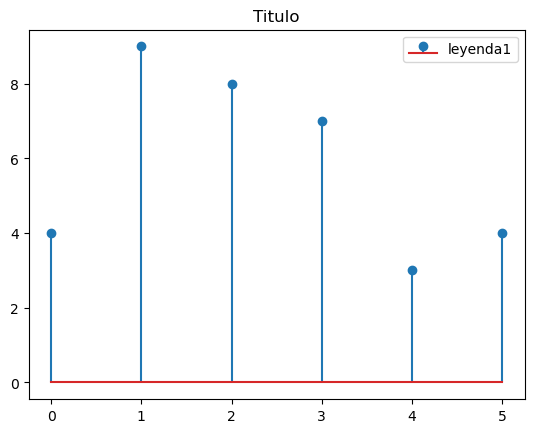

In [15]:
from matplotlib import pyplot as plt
import numpy
x=[4,9,8,7,3,4]
plt.stem(x)
plt.title("Titulo")
plt.legend(["leyenda1"])


¿Con cuál de las cuatro representaciones has obtenido mejores resultados? ¿Puedes razonar alguna explicación para ello?